# 1. Import Packages

In [2]:
# Import necessary packages
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os

# 2. Mount Drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Import and Create Dataset

Number of instances: 264


<ipython-input-4-d195abac1cd3>:34: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=filename)


Dataset prepared:
<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cache_path  285 non-null    object
 1   label       285 non-null    object
dtypes: object(2)
memory usage: 6.7+ KB
None


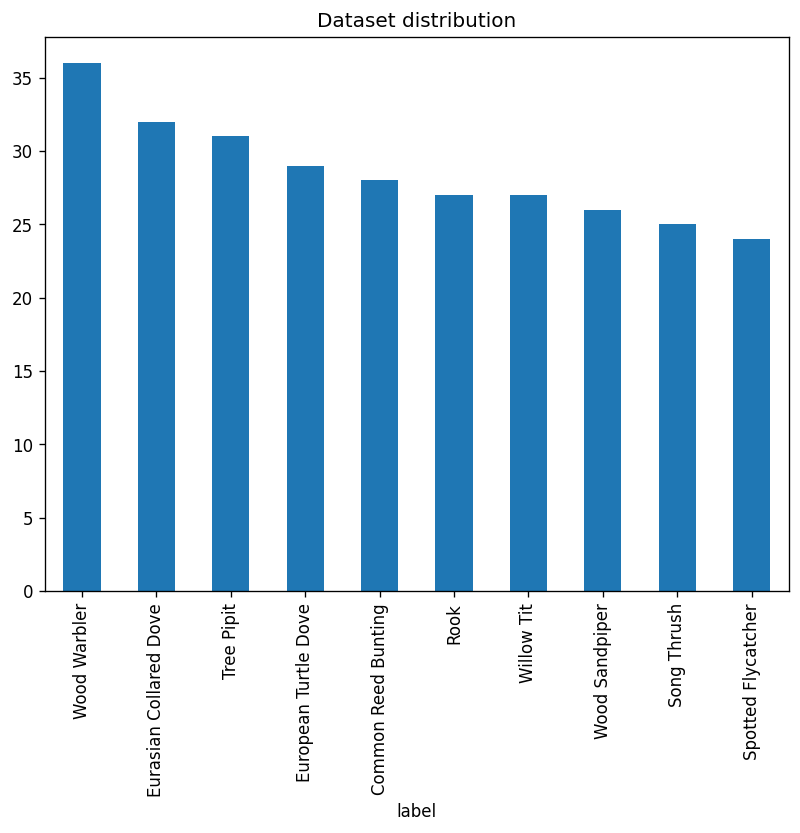

Train: 228
Test: 57


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
# Load dataset
birdsong = pd.read_csv('/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/birdsong_metadata.csv')
birdsong = birdsong[['file_id', 'english_cname']]  # Select relevant columns
bird = birdsong.to_dict()
ids = list(bird['file_id'].values())
print('Number of instances:', len(ids))
bird_name = list(bird['english_cname'].values())

# Preprocess and cache MFCC features to avoid recomputation
if not os.path.exists('/content/drive/MyDrive/thesis/mfcc_cache'):
    os.makedirs('/content/drive/MyDrive/thesis/mfcc_cache')

def cache_mfcc_features(row):
    cache_path = f"/content/drive/MyDrive/thesis/mfcc_cache/{row['file_id']}.npy"
    if not os.path.exists(cache_path):
        y, sr = librosa.load(row['filename'], offset=row['offset'], duration=5)
        S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
        np.save(cache_path, mfccs)
    return cache_path

# Create dataset
import re
dataset = []
for filename in glob.iglob('/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/*.flac'):
    if filename.endswith('.flac'):
        identity = filename.split('/')[-1][:-5]
        match = re.search(r'\d+', identity)
        if match:
            identity_num = int(match.group())
            if identity_num in ids:
                index = ids.index(identity_num)
                label = bird_name[index]
                duration = librosa.get_duration(filename=filename)

                if duration >= 5:
                    slice_size = 5
                    iterations = int((duration - slice_size) / (slice_size - 1)) + 1
                    initial_offset = (duration - ((iterations * (slice_size - 1)) + 1)) / 2

                    for i in range(iterations):
                        offset = initial_offset + i * (slice_size - 1)
                        cache_path = cache_mfcc_features({"file_id": identity_num, "filename": filename, "offset": offset})
                        dataset.append({"cache_path": cache_path, "label": label})

dataset = pd.DataFrame(dataset)
dataset = dataset[dataset['label'].isin(list(dataset.label.value_counts()[:10].index))]
print("Dataset prepared:")
print(dataset.info())

# Visualize distribution
plt.figure(figsize=(8, 6), dpi=120)
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

# Split data into training and test sets
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print("Train: %i" % len(train))
print("Test: %i" % len(test))

# PyTorch dataset class
class BirdSoundDataset(Dataset):
    def __init__(self, data, encoder):
        self.data = data
        self.encoder = encoder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        mfccs = np.load(row['cache_path'])
        mfccs = torch.tensor(mfccs, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.encoder.transform([row['label']])[0], dtype=torch.long)
        return mfccs, label

# Encode labels
encoder = LabelEncoder()
encoder.fit(train.label)

# Create dataset and dataloaders
train_dataset = BirdSoundDataset(train, encoder)
test_dataset = BirdSoundDataset(test, encoder)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 4. Define CNN

In [5]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Model instantiation
num_classes = len(encoder.classes_)
model = CNNModel(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

# 5. Training

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with loss and accuracy tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


Epoch 1/50, Training Loss: 4.5452, Validation Loss: 3.1345, Training Accuracy: 0.1184, Validation Accuracy: 0.1404


100%|██████████| 8/8 [00:02<00:00,  3.53it/s]


Epoch 2/50, Training Loss: 3.1090, Validation Loss: 2.3305, Training Accuracy: 0.2412, Validation Accuracy: 0.3860


100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


Epoch 3/50, Training Loss: 1.9757, Validation Loss: 1.7969, Training Accuracy: 0.3421, Validation Accuracy: 0.4386


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch 4/50, Training Loss: 1.6805, Validation Loss: 1.6473, Training Accuracy: 0.4342, Validation Accuracy: 0.6491


100%|██████████| 8/8 [00:02<00:00,  3.77it/s]


Epoch 5/50, Training Loss: 1.3804, Validation Loss: 1.4367, Training Accuracy: 0.5482, Validation Accuracy: 0.6316


100%|██████████| 8/8 [00:02<00:00,  3.73it/s]


Epoch 6/50, Training Loss: 1.1090, Validation Loss: 1.0945, Training Accuracy: 0.6798, Validation Accuracy: 0.8246


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


Epoch 7/50, Training Loss: 0.8216, Validation Loss: 0.8601, Training Accuracy: 0.7588, Validation Accuracy: 0.8070


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 8/50, Training Loss: 0.6604, Validation Loss: 0.6712, Training Accuracy: 0.8114, Validation Accuracy: 0.9123


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch 9/50, Training Loss: 0.6675, Validation Loss: 0.5480, Training Accuracy: 0.7588, Validation Accuracy: 0.8947


100%|██████████| 8/8 [00:02<00:00,  3.77it/s]


Epoch 10/50, Training Loss: 0.4677, Validation Loss: 0.4319, Training Accuracy: 0.8509, Validation Accuracy: 0.9123


100%|██████████| 8/8 [00:02<00:00,  3.70it/s]


Epoch 11/50, Training Loss: 0.3060, Validation Loss: 0.4451, Training Accuracy: 0.8991, Validation Accuracy: 0.9123


100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


Epoch 12/50, Training Loss: 0.3622, Validation Loss: 0.2855, Training Accuracy: 0.9386, Validation Accuracy: 0.9123


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


Epoch 13/50, Training Loss: 0.3563, Validation Loss: 0.2962, Training Accuracy: 0.8684, Validation Accuracy: 0.9298


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch 14/50, Training Loss: 0.1833, Validation Loss: 0.1993, Training Accuracy: 0.9430, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.63it/s]


Epoch 15/50, Training Loss: 0.1468, Validation Loss: 0.2043, Training Accuracy: 0.9605, Validation Accuracy: 0.9825


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Epoch 16/50, Training Loss: 0.0995, Validation Loss: 0.2007, Training Accuracy: 0.9825, Validation Accuracy: 0.9825


100%|██████████| 8/8 [00:02<00:00,  3.60it/s]


Epoch 17/50, Training Loss: 0.0796, Validation Loss: 0.0923, Training Accuracy: 0.9781, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch 18/50, Training Loss: 0.0668, Validation Loss: 0.1060, Training Accuracy: 0.9781, Validation Accuracy: 0.9825


100%|██████████| 8/8 [00:02<00:00,  3.64it/s]


Epoch 19/50, Training Loss: 0.0362, Validation Loss: 0.0709, Training Accuracy: 0.9956, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


Epoch 20/50, Training Loss: 0.0219, Validation Loss: 0.0635, Training Accuracy: 1.0000, Validation Accuracy: 0.9825


100%|██████████| 8/8 [00:02<00:00,  3.73it/s]


Epoch 21/50, Training Loss: 0.0183, Validation Loss: 0.0497, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Epoch 22/50, Training Loss: 0.0178, Validation Loss: 0.0403, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch 23/50, Training Loss: 0.0144, Validation Loss: 0.0657, Training Accuracy: 1.0000, Validation Accuracy: 0.9825


100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


Epoch 24/50, Training Loss: 0.0143, Validation Loss: 0.0302, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


Epoch 25/50, Training Loss: 0.0106, Validation Loss: 0.0331, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.63it/s]


Epoch 26/50, Training Loss: 0.0110, Validation Loss: 0.0318, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Epoch 27/50, Training Loss: 0.0074, Validation Loss: 0.0254, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch 28/50, Training Loss: 0.0071, Validation Loss: 0.0290, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.72it/s]


Epoch 29/50, Training Loss: 0.0059, Validation Loss: 0.0261, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


Epoch 30/50, Training Loss: 0.0064, Validation Loss: 0.0219, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


Epoch 31/50, Training Loss: 0.0048, Validation Loss: 0.0169, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Epoch 32/50, Training Loss: 0.0050, Validation Loss: 0.0176, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch 33/50, Training Loss: 0.0053, Validation Loss: 0.0240, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


Epoch 34/50, Training Loss: 0.0038, Validation Loss: 0.0149, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.92it/s]


Epoch 35/50, Training Loss: 0.0052, Validation Loss: 0.0199, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.67it/s]


Epoch 36/50, Training Loss: 0.0043, Validation Loss: 0.0169, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


Epoch 37/50, Training Loss: 0.0076, Validation Loss: 0.0139, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch 38/50, Training Loss: 0.0031, Validation Loss: 0.0275, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


Epoch 39/50, Training Loss: 0.0028, Validation Loss: 0.0122, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


Epoch 40/50, Training Loss: 0.0026, Validation Loss: 0.0078, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch 41/50, Training Loss: 0.0039, Validation Loss: 0.0180, Training Accuracy: 1.0000, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch 42/50, Training Loss: 0.0032, Validation Loss: 0.0353, Training Accuracy: 1.0000, Validation Accuracy: 0.9825


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch 43/50, Training Loss: 0.0098, Validation Loss: 0.0658, Training Accuracy: 1.0000, Validation Accuracy: 0.9825


100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


Epoch 44/50, Training Loss: 0.0082, Validation Loss: 0.0049, Training Accuracy: 0.9956, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


Epoch 45/50, Training Loss: 0.0062, Validation Loss: 0.0462, Training Accuracy: 0.9956, Validation Accuracy: 0.9825


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


Epoch 46/50, Training Loss: 0.0090, Validation Loss: 0.0145, Training Accuracy: 0.9956, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


Epoch 47/50, Training Loss: 0.0676, Validation Loss: 0.0061, Training Accuracy: 0.9649, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


Epoch 48/50, Training Loss: 0.0266, Validation Loss: 0.1440, Training Accuracy: 0.9912, Validation Accuracy: 0.9474


100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


Epoch 49/50, Training Loss: 0.1120, Validation Loss: 0.0302, Training Accuracy: 0.9693, Validation Accuracy: 1.0000


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Epoch 50/50, Training Loss: 0.0463, Validation Loss: 0.0221, Training Accuracy: 0.9912, Validation Accuracy: 1.0000


# 6. Results

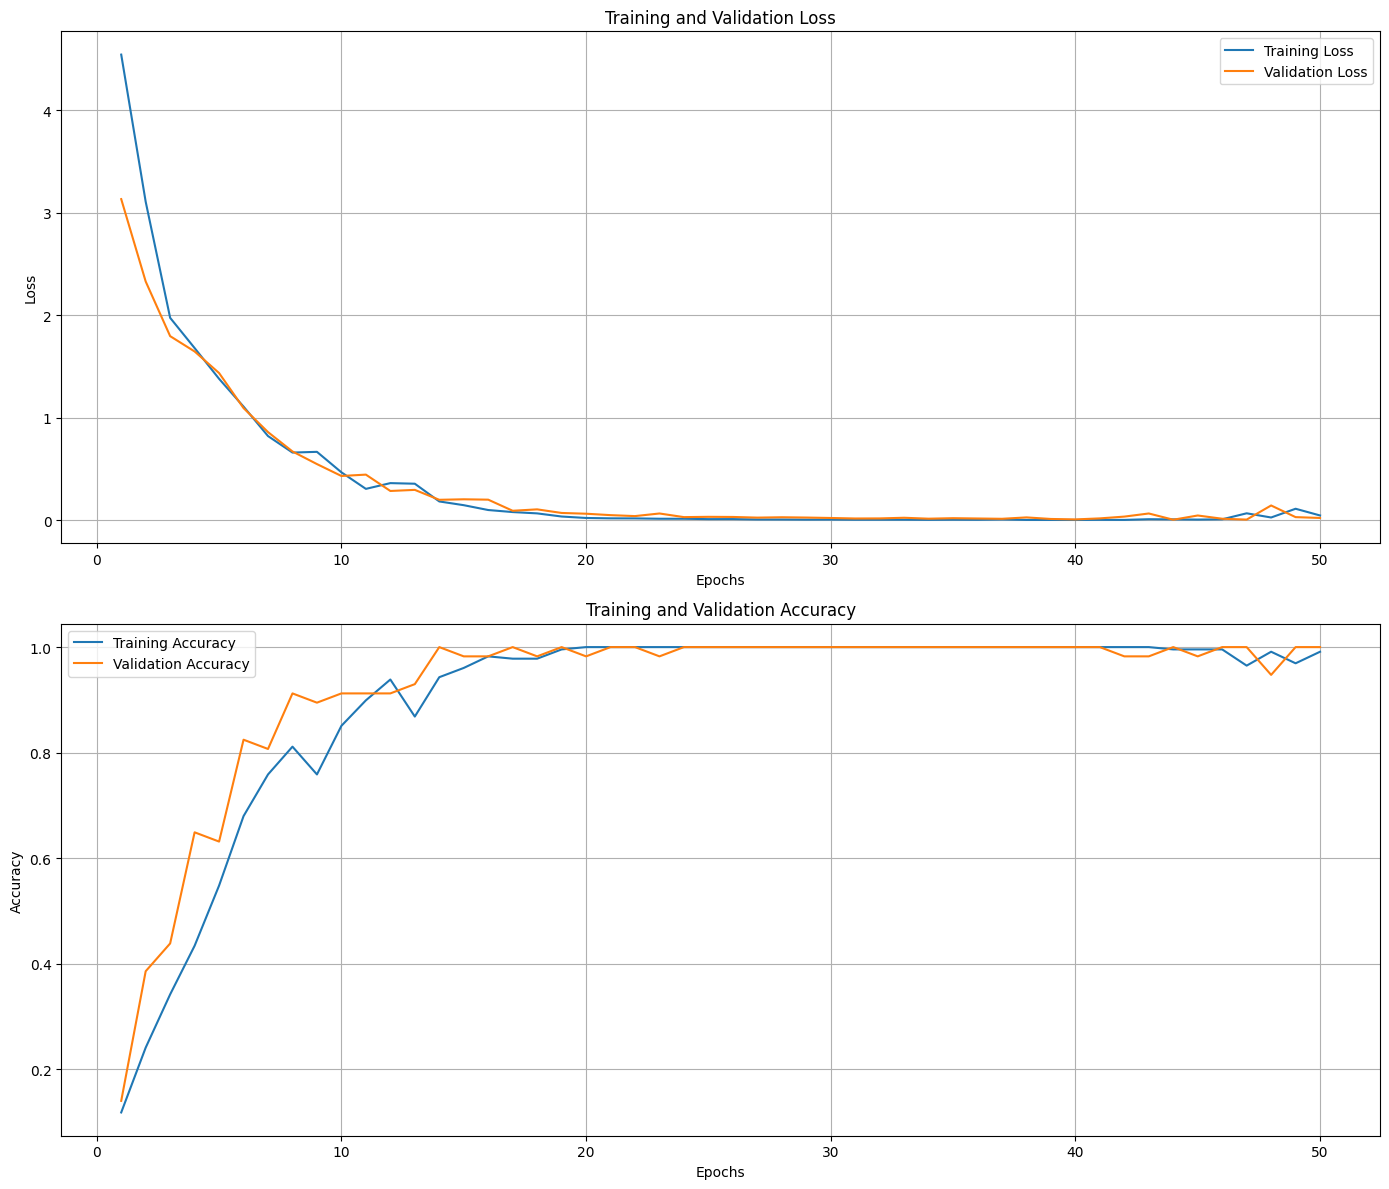

                        precision    recall  f1-score   support

   Common Reed Bunting       1.00      1.00      1.00         5
Eurasian Collared Dove       1.00      1.00      1.00         8
  European Turtle Dove       1.00      1.00      1.00         4
                  Rook       1.00      1.00      1.00         4
           Song Thrush       1.00      1.00      1.00         6
    Spotted Flycatcher       1.00      1.00      1.00         1
            Tree Pipit       1.00      1.00      1.00         8
            Willow Tit       1.00      1.00      1.00         8
        Wood Sandpiper       1.00      1.00      1.00         6
          Wood Warbler       1.00      1.00      1.00         7

              accuracy                           1.00        57
             macro avg       1.00      1.00      1.00        57
          weighted avg       1.00      1.00      1.00        57



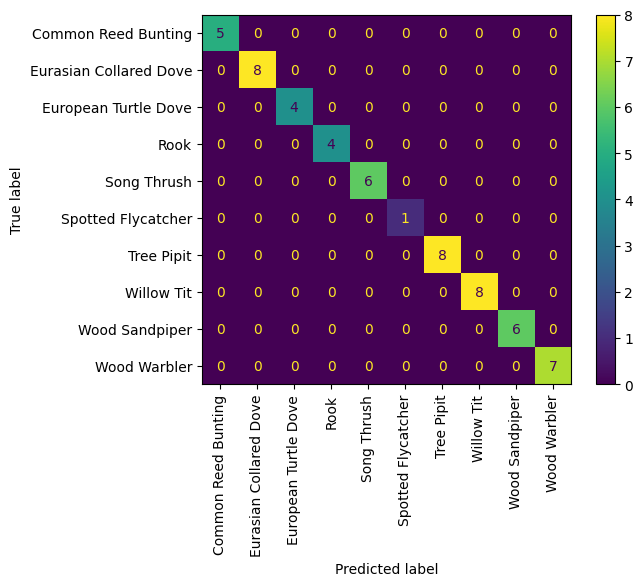

In [7]:

# Plotting loss and accuracy curves
plt.figure(figsize=(14, 12))
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Display confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=encoder.classes_))
conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()


